In [86]:
!pip install graphviz
!pip install pydot

In [87]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [88]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão
dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [89]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [90]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [91]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [92]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [93]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


In [94]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [95]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


In [96]:
from sklearn.tree import export_graphviz

import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=['não', 'sim'], feature_names=features)
graph = graphviz.Source(dot_data)

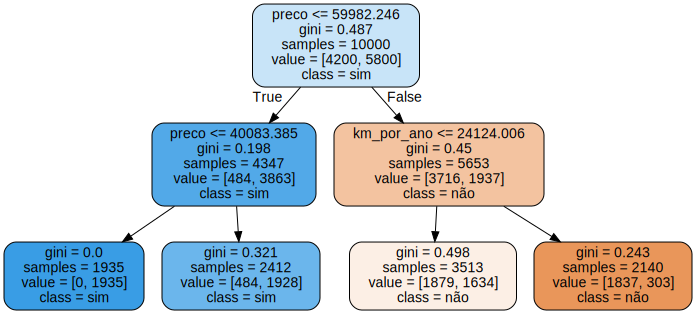

In [97]:
graph

# Explorando hiper parâmetros em uma dimensão

In [98]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, train_score, test_score))
  tabela = [max_depth, train_score, test_score]
  return tabela


resultados = [roda_arvore_de_decisao(i) for i in range (1, 33)]
resultados = pd.DataFrame(resultados, columns = ['max_depth', 'train', 'test'])
resultados.head()

max_depth = 1, treino = 75.79, teste = 75.78
max_depth = 2, treino = 75.79, teste = 75.78
max_depth = 3, treino = 78.75, teste = 78.67
max_depth = 4, treino = 78.79, teste = 78.63
max_depth = 5, treino = 78.94, teste = 78.56
max_depth = 6, treino = 79.17, teste = 78.12
max_depth = 7, treino = 79.50, teste = 77.96
max_depth = 8, treino = 79.89, teste = 77.86
max_depth = 9, treino = 80.46, teste = 77.38
max_depth = 10, treino = 81.16, teste = 77.19
max_depth = 11, treino = 82.03, teste = 76.97
max_depth = 12, treino = 82.89, teste = 76.49
max_depth = 13, treino = 83.95, teste = 75.81
max_depth = 14, treino = 85.03, teste = 75.66
max_depth = 15, treino = 86.14, teste = 75.16
max_depth = 16, treino = 87.19, teste = 75.11
max_depth = 17, treino = 88.31, teste = 74.74
max_depth = 18, treino = 89.26, teste = 74.33
max_depth = 19, treino = 90.32, teste = 74.34
max_depth = 20, treino = 91.32, teste = 74.22
max_depth = 21, treino = 92.14, teste = 73.80
max_depth = 22, treino = 93.02, teste = 73.

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


<AxesSubplot: xlabel='max_depth', ylabel='train'>

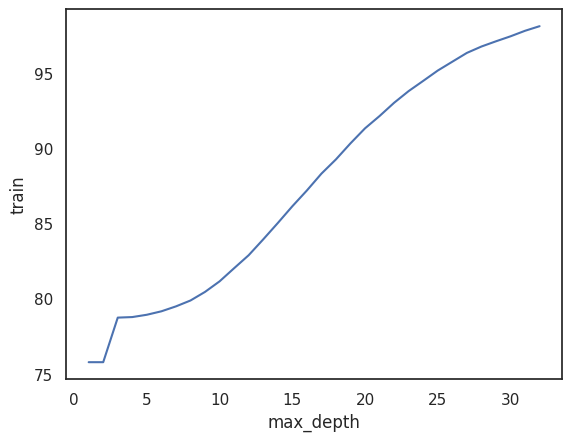

In [99]:
import seaborn as sns

sns.lineplot(data = resultados, x = 'max_depth', y = 'train')

# OVERFIT: Ficou perfeito para o treino e ruim para o teste

<AxesSubplot: xlabel='max_depth', ylabel='train'>

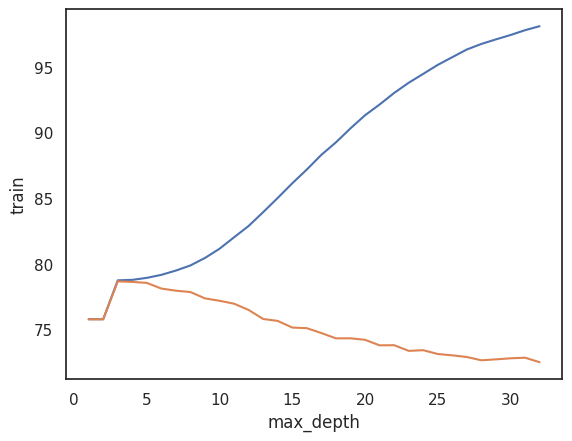

In [100]:
sns.lineplot(data = resultados, x = 'max_depth', y = 'train')
sns.lineplot(data = resultados, x = 'max_depth', y = 'test')

In [101]:
resultados.sort_values('test', ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


# Explorando hiper parâmetros em duas dimensões

In [102]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela


def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [128, 192, 256, 512]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78
max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78
max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78
max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.67
max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
max_depth = 3, min_samples_leaf = 512, treino = 77.53, teste = 77.50
max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.67
max_depth = 4, min_samples_leaf = 192, treino = 78.75, teste = 78.67
max_depth = 4, min_samples_leaf = 

,max_depth,min_samples_leaf,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219


In [103]:
resultados.sort_values('test', ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


In [104]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,6.863211e-17,0.354588,0.240852
min_samples_leaf,6.863211e-17,1.000000e+00,-0.637649,-0.440661
train,3.545878e-01,-6.376494e-01,1.000000,0.909222
test,2.408525e-01,-4.406611e-01,0.909222,1.000000


<AxesSubplot: >

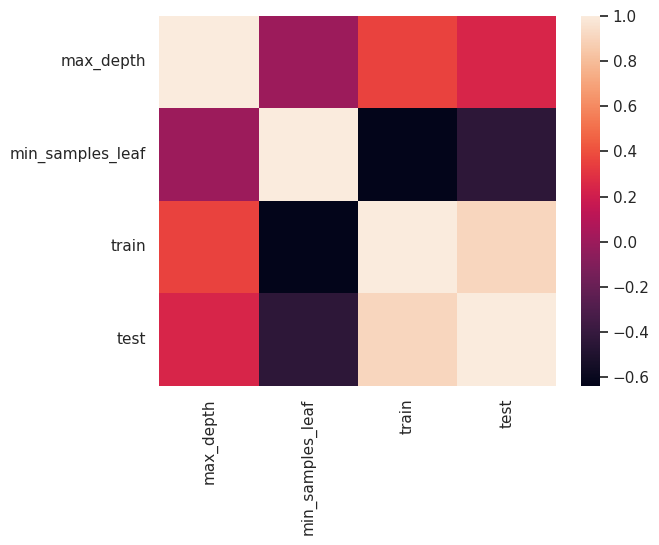

In [105]:
sns.heatmap(corr)

array([[<AxesSubplot: xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot: xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot: xlabel='train', ylabel='max_depth'>,
        <AxesSubplot: xlabel='test', ylabel='max_depth'>],
       [<AxesSubplot: xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot: xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot: xlabel='train', ylabel='min_samples_leaf'>,
        <AxesSubplot: xlabel='test', ylabel='min_samples_leaf'>],
       [<AxesSubplot: xlabel='max_depth', ylabel='train'>,
        <AxesSubplot: xlabel='min_samples_leaf', ylabel='train'>,
        <AxesSubplot: xlabel='train', ylabel='train'>,
        <AxesSubplot: xlabel='test', ylabel='train'>],
       [<AxesSubplot: xlabel='max_depth', ylabel='test'>,
        <AxesSubplot: xlabel='min_samples_leaf', ylabel='test'>,
        <AxesSubplot: xlabel='train', ylabel='test'>,
        <AxesSubplot: xlabel='test', ylabel='test'>]], dty

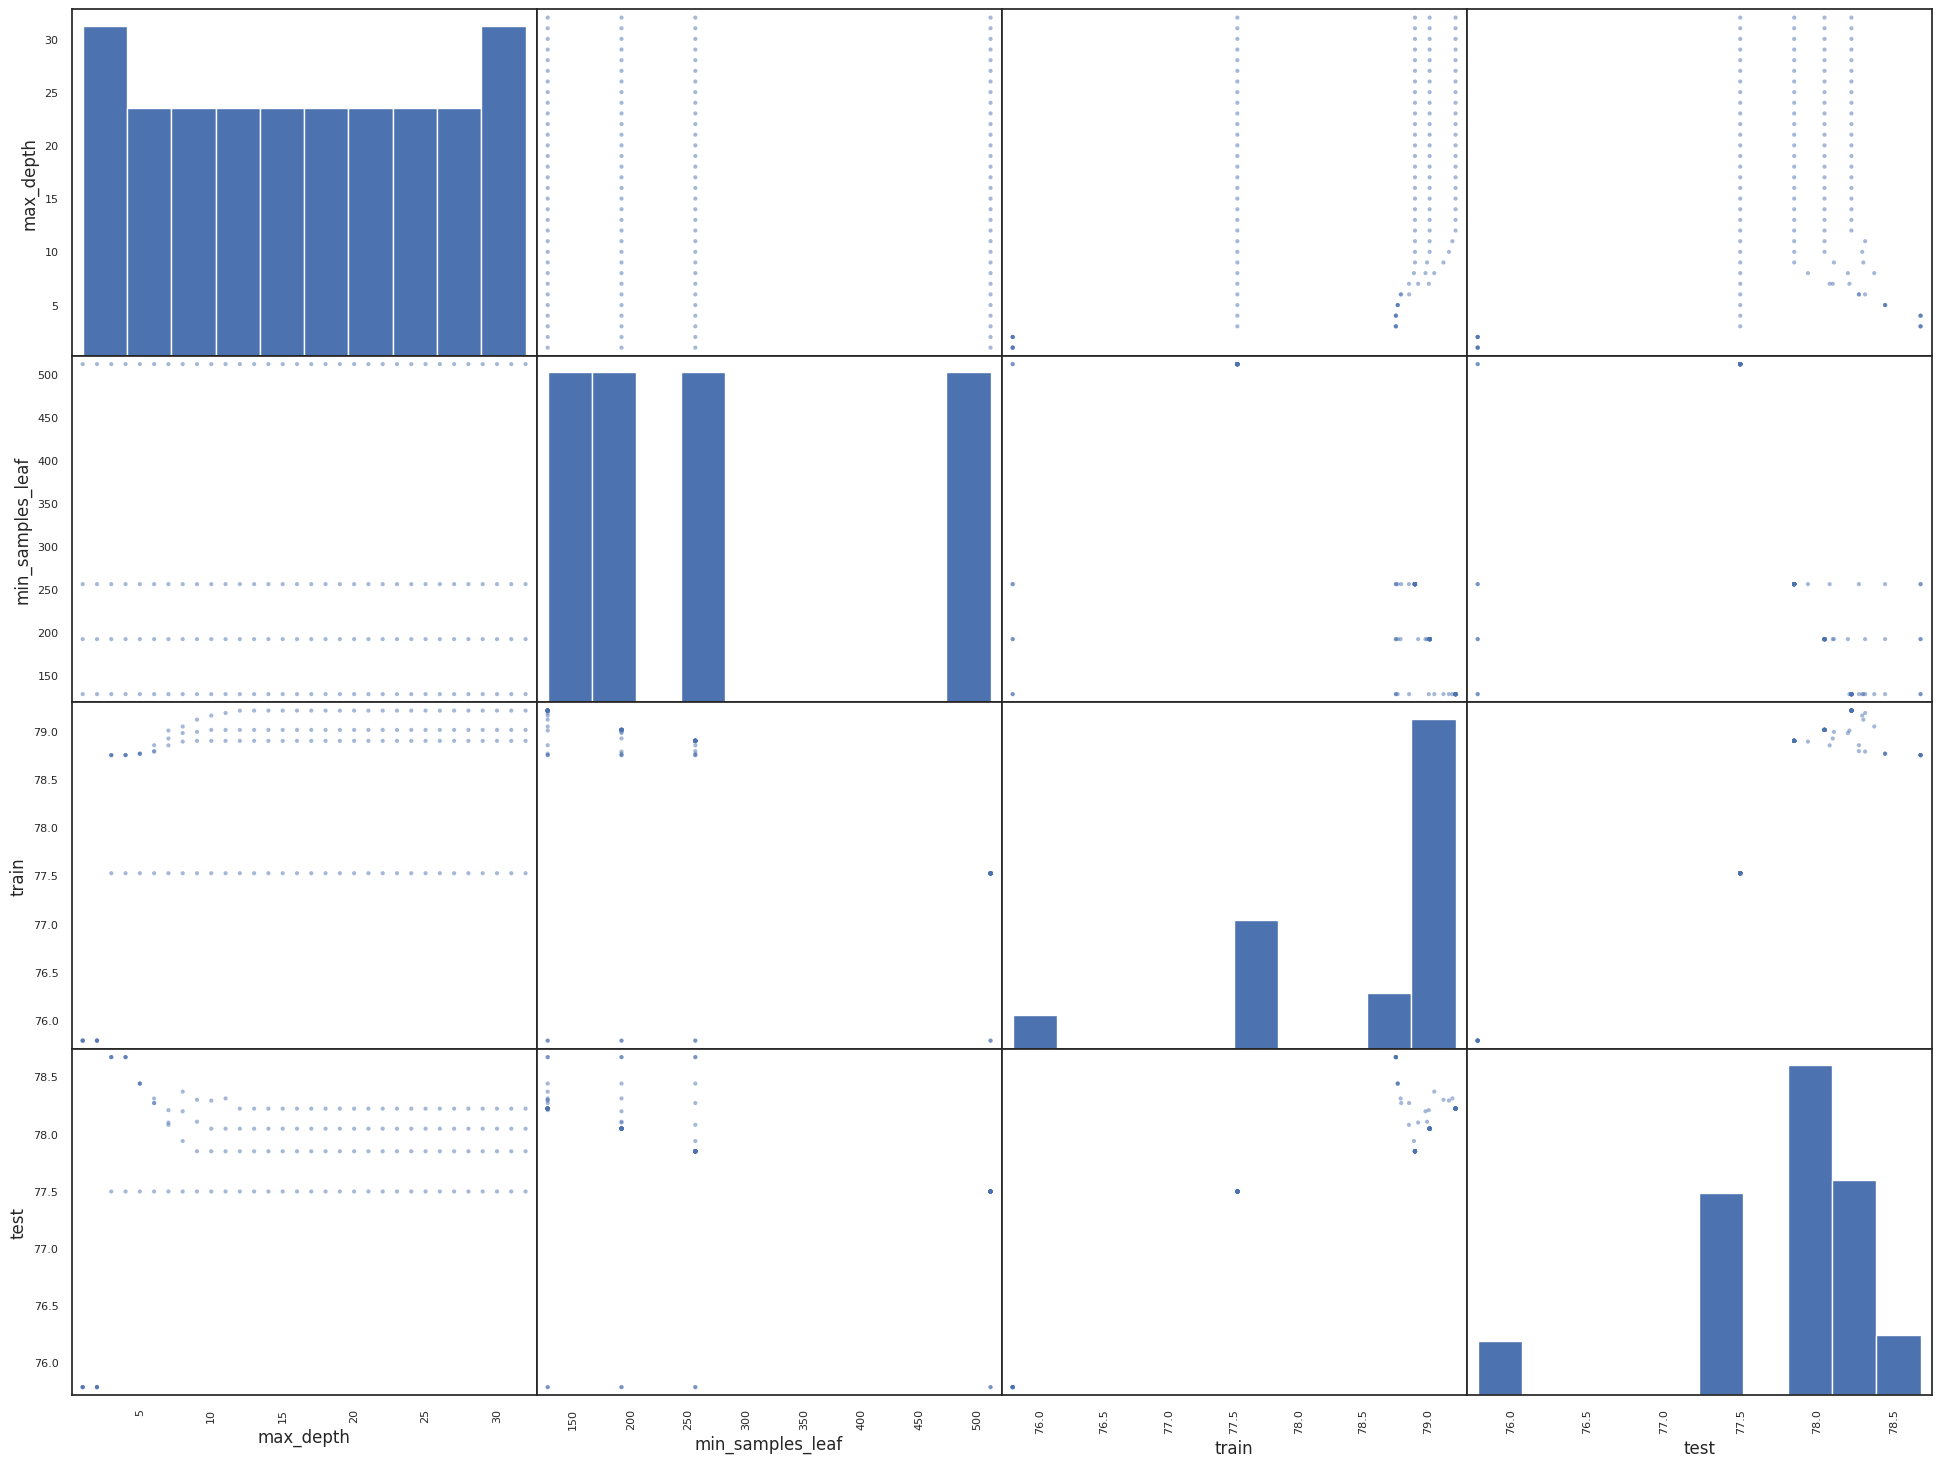

In [106]:
pd.plotting.scatter_matrix(resultados, figsize=(24, 18))

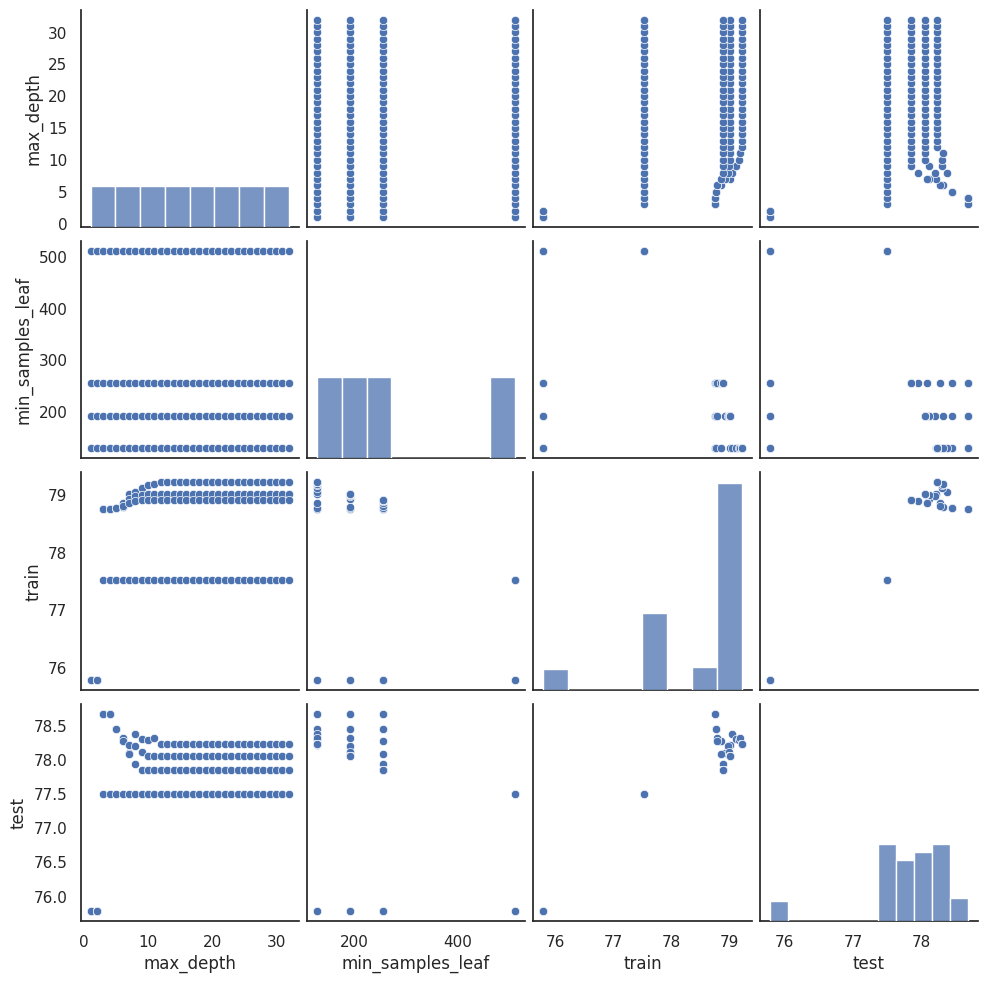

In [107]:
sns.pairplot(resultados)

/tmp/ipykernel_5490/3792064364.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot: >

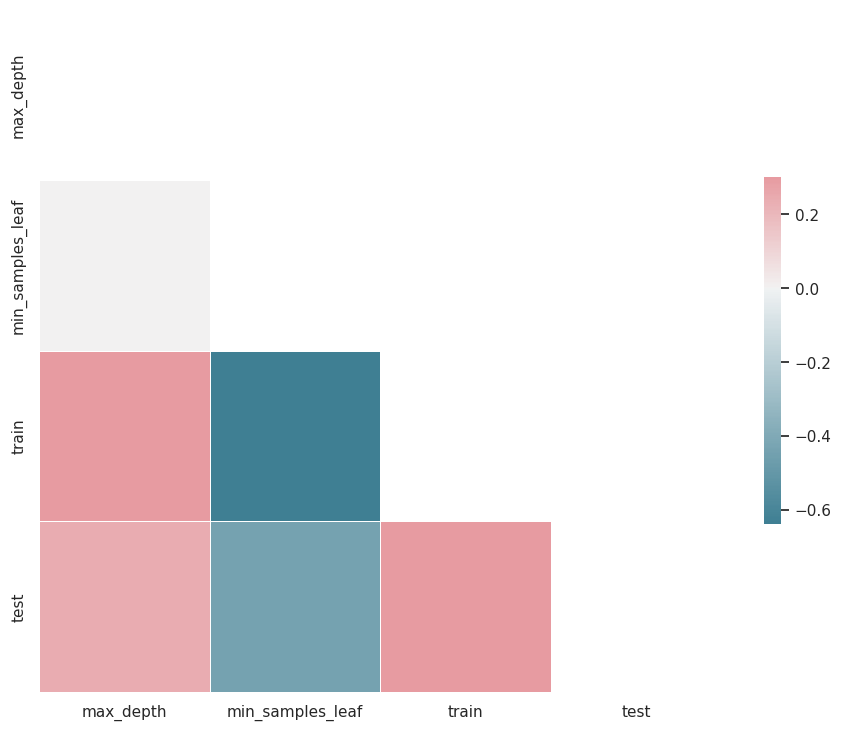

In [108]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [109]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


# Explorando 3 hiper parâmetros

In [111]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        for min_samples_split in [32, 64, 128, 256]:
          tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
          resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()

KeyboardInterrupt: 

# Explorando espaço de hiper parâmetros com GSCV

In [113]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion': ['gini', 'entropy'],
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv = GroupKFold(n_splits=10))

busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008705,0.000933,0.001539,0.000198,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.007197,0.000432,0.001333,0.000218,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.007276,0.000641,0.001271,0.000057,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.007464,0.000635,0.001370,0.000228,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.007347,0.000506,0.001334,0.000189,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [114]:
print(busca.best_params_)
print(busca.best_score_)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
0.7867263337284333


In [115]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


In [116]:
from sklearn.metrics import accuracy_score 

# evitar essa abordagem pois ela é otimista

predicoes = melhor.predict(x_azar) 
accuracy = accuracy_score(predicoes, y_azar) * 100

print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


# Infelizmente como o pandas não suporta neste validation com group k fold não conseguimos prever o resultado para novos grupos

In [117]:
# from sklearn.model_selection import cross_val_score

# cross_val_score(busca, x_azar, y_azar, cv= GroupKFold(n_splits=10), groups = dados.modelo)

In [118]:
from sklearn.model_selection import GridSearchCV, KFold

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion': ['gini', 'entropy'],
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv = KFold(n_splits=10, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007550,0.000628,0.001281,0.000112,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
1,0.007009,0.000181,0.001263,0.000097,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
2,0.007019,0.000255,0.001273,0.000100,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
3,0.006901,0.000159,0.001255,0.000062,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
4,0.006921,0.000175,0.001349,0.000276,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1


In [119]:
scores = cross_val_score(busca, x_azar, y_azar, cv= KFold(n_splits=5, shuffle=True))
scores

array([0.77  , 0.79  , 0.7875, 0.7845, 0.8025])

In [120]:
def imprime_scores(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [121]:
imprime_scores(scores)

Accuracy médio 78.69
Intervalo [76.60, 80.78]


In [122]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


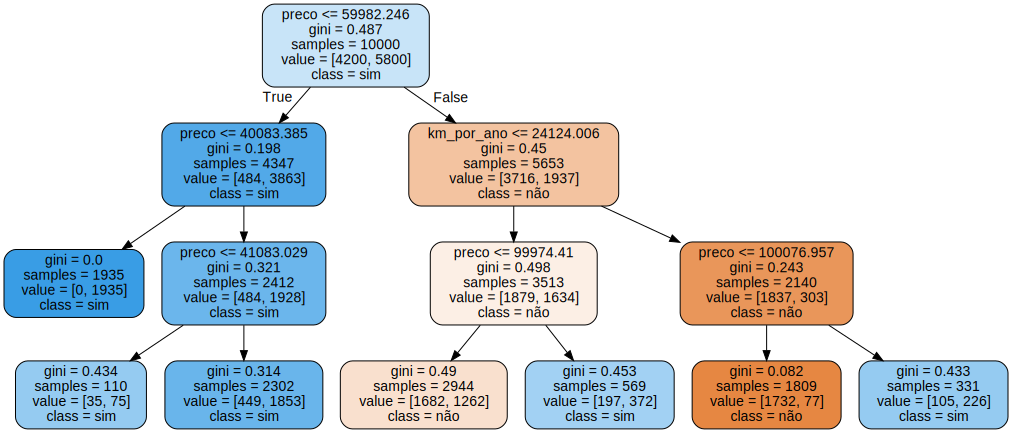

In [123]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True, class_names=["não","sim"], feature_names=features)
graph = graphviz.Source(dot_data)
graph

# Busca Aleatória: Random Search

In [124]:
from sklearn.model_selection import RandomizedSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, n_iter = 16, cv = KFold(n_splits = 5), random_state = SEED)

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009383,0.001065,0.001371,0.000069,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.4330,0.4525,0.771,0.742,0.7725,0.6342,0.156817,1
1,0.006511,0.000207,0.001383,0.000168,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4015,0.4165,0.771,0.766,0.7725,0.6255,0.176848,11
2,0.006480,0.000158,0.001539,0.000300,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4015,0.4165,0.771,0.766,0.7725,0.6255,0.176848,11
3,0.010708,0.000592,0.001402,0.000074,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.4240,0.4535,0.771,0.750,0.7445,0.6286,0.155544,5
4,0.010620,0.000585,0.001372,0.000122,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4240,0.4535,0.771,0.750,0.7445,0.6286,0.155544,5


In [126]:
scores = cross_val_score(busca, x_azar, y_azar, cv= KFold(n_splits=5, shuffle=True))
imprime_scores(scores)

Accuracy médio 78.69
Intervalo [76.70, 80.68]


In [128]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=128, min_samples_split=128)


# Customizando o espaço de hiper parâmetros

In [129]:
from scipy.stats import randint

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, n_iter = 16, cv = KFold(n_splits = 5, shuffle=True), random_state = SEED)


busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009635,0.000950,0.001688,0.000312,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.012786,0.000528,0.001496,0.000223,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.011145,0.000343,0.001626,0.000271,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.015845,0.001513,0.001596,0.000150,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.012292,0.001079,0.001768,0.000510,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


In [131]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_scores(scores)
melhor = busca.best_estimator_
print(melhor)

Accuracy médio 78.70
Intervalo [76.85, 80.55]
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


In [134]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +- (0.024) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 +- (0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 +- (0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +- (0.019) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 +- (0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +- (0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 +- (0.020) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +- (0.009) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 +- (0.014) {'criterion': 'entropy', 